# Evaluating Task Performance

## Introduction

All medical images are created for a purpose, to detect, diagnose, quantify, monitor, etc. For this reason, [OIC](https://aapm.onlinelibrary.wiley.com/doi/full/10.1118/1.4881148) 

**Add bit to recruit results.csv for task performance, maybe add oct2py wrapper for LCD-CT**

## 1. Making a Low Contrast Detectability Dataset

Using the simulation tools provided by [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms), make a dataset of the MITA-LCD phantom (Catphan 600 CCT189 Module) at 10 dose levels with 200 repeats each using a Siemens Somatom Definition AS Scanner, this can be done with the following config file and the [`make_phantoms`](https://pediatriciqphantoms.readthedocs.io/en/latest/usage.html#command-line-interface) command line program available after [installing pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms?tab=readme-ov-file#start-here):

```toml
# LCD.toml

[[simulation]]

# directories
image_directory = "/gpfs_projects/brandon.nelson/RSTs/LCD-CT"
# phantoms
model = ['MITA-LCD', 'uniform'] # <-- current options include ['CTP404', 'MITA-LCD', 'UNIFORM']
diameter = [200] # <-- units in mm
reference_diameter = 200 # <-- diameter in mm of the real phantom for comparison

# acquisition
framework = "MIRT" # CT simulation framework options include ['MIRT'] <https://github.com/JeffFessler/mirt>
nsims = 200 # <-- number of simulations to perform with different noise instantiations
ndetectors = 880           # number of detector columns (set it to be large enough to cover the projected FOV to avoid truncation)
nangles = 1160 # <-- number of views in a rotation (na=1160 based on ZengEtAl2015-IEEE-NuclearScience-v62n5:"A Simple Low-Dose X-Ray CT Simulation From High-Dose Scan")
aec_on = true # (aec built in to ped xcat) <-- 'aec' = automatic exposure control, when `true`, it ensures constant noise levels for all `patient_diameters` (see `reference_dose_level` for more info)
add_noise = true # <-- if true adds Poisson noise, noise magnitude set by `reference_dose_level`, noise texture set by reconstructed field of view (currently fov = 110# patient_diameter) 
full_dose = 3e5 # <-- units of photons per pixel
dose_level = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # <-- units of photons in list

# acquisition geometry # CT geometry (the following parameter values simulate Siemens Force) 
sid = 595          #(mm) source-to-isocenter distance (value based on AAPM LDCT data dicom header)
sdd = 1085.6          # source-to-detector distance
# isocenter-to-detector distance dod = sdd - sid 
                      
detector_size = 1        # detector column size 
detector_offset = 1.25    # lateral shift of detector

# reconstruction
fov = 340  # <-- FOV in mm of adult protocol used in scanning real physical phantom for comparison
matrix_size = 512 # <-- reconstructed matrix size in pixels (square, equal on both sides)
fbp_kernel = 'hanning,2.05' # 'hanning,xxx', xxx = the cutoff frequency, see fbp2_window.m in MIRT for details.
                        #'hanning,2.05' approximate a sharp kernel D45 in Siemens Force.
                        #'hanning, 0.85' approximate a smooth kernel B30 in
                        #Siemens Force.
```

Then run the simulation using `make_phantoms`:

```bash
make_phantoms LCD.toml
```

The result as a simulated dataset of 200 repeats of the MITA-LCD phantom simulated on a Siemens Somatom Definition AS CT scanner at 10 increasing dose levels.

We can then use the Low Contrast Detectability CT Toolbox (LCD-CT) to evaluate detectability as a function of dose as demonstrated below:

(a pre-generated version is also available for download from **Zenodo (TODO)**, or use the smaller dataset)

```shell
make_phantoms LCD.toml
```

See [DIDSR/pediatricIQphantoms/running_simulations](https://pediatriciqphantoms.readthedocs.io/en/latest/notebooks/00_running_simulations.html) for more details on interactive simulations.

In [1]:
from pathlib import Path

from pediatricIQphantoms import run_batch_sim

import tomli
with open('LCD.toml', 'rb') as f:
    config_file = tomli.load(f)
config = config_file['simulation'][0]

base_dir = Path('data/small')
base_dir = Path('data/full')


if not base_dir.exists():
    config['image_directory'] = base_dir
    config['dose_level'] = [.25, 0.5, 1]
    config['nsims'] = 5
    metadata = run_batch_sim(verbose=False, **config)
config

{'image_directory': 'data/full',
 'model': ['MITA-LCD', 'uniform'],
 'diameter': [200],
 'reference_diameter': 200,
 'framework': 'MIRT',
 'nsims': 200,
 'ndetectors': 880,
 'nangles': 1160,
 'aec_on': True,
 'add_noise': True,
 'full_dose': 3000000.0,
 'dose_level': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'sid': 595,
 'sdd': 1085.6,
 'detector_size': 1,
 'detector_offset': 1.25,
 'fov': 340,
 'matrix_size': 512,
 'fbp_kernel': 'hanning,2.05'}

In [2]:
!pip install matplotlib -q

In [3]:
import pandas as pd

meta = pd.read_csv(base_dir / 'metadata.csv')
meta.file = meta.file.apply(lambda o: base_dir.absolute() / o)
meta = meta[meta.phantom.isin(['MITA-LCD', 'uniform'])]
meta

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
0,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 10% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
1,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 10% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
2,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 10% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,2,/home/brandon.nelson/Dev/Regulatory_Science_To...
3,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 10% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,3,/home/brandon.nelson/Dev/Regulatory_Science_To...
4,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 10% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,4,/home/brandon.nelson/Dev/Regulatory_Science_To...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999,20.0 cm uniform,0,3000000.0 photons 20.0 cm uniform 100% dose fb...,9,simulation,20.0,2,infant,uniform,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,197,/home/brandon.nelson/Dev/Regulatory_Science_To...
4000,20.0 cm uniform,0,3000000.0 photons 20.0 cm uniform 100% dose fb...,9,simulation,20.0,2,infant,uniform,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,198,/home/brandon.nelson/Dev/Regulatory_Science_To...
4001,20.0 cm uniform,0,3000000.0 photons 20.0 cm uniform 100% dose fb...,9,simulation,20.0,2,infant,uniform,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,199,/home/brandon.nelson/Dev/Regulatory_Science_To...
4002,20.0 cm uniform,0,3000000.0 photons 20.0 cm uniform 100% dose fb...,9,noise free,20.0,2,infant,uniform,Siemens Definition AS+ (simulated),NaN,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...


In [4]:
sorted(meta['effective diameter [cm]'].unique()), meta.series.unique()

([20.0], array(['simulation', 'noise free', 'ground truth'], dtype=object))

In [5]:
diam = 20
dose = 100
recon = 'fbp'
sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]
sample.head()

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
1800,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
1801,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
1802,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,2,/home/brandon.nelson/Dev/Regulatory_Science_To...
1803,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,3,/home/brandon.nelson/Dev/Regulatory_Science_To...
1804,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,4,/home/brandon.nelson/Dev/Regulatory_Science_To...


In [6]:
meta[(meta['effective diameter [cm]']==diam) & (meta.phantom == 'MITA-LCD') & (meta.series == 'ground truth')]

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
2001,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,9,ground truth,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),NaN,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...


In [7]:
meta.phantom.unique()

array(['MITA-LCD', 'uniform'], dtype=object)

In [8]:
import pydicom
import numpy as np
def load_dicom(dcm_file):
    dcm = pydicom.dcmread(dcm_file)
    return (dcm.pixel_array + int(dcm.RescaleIntercept)).astype(float)

In [9]:
diam = 20
dose = 100
recon = 'fbp'
sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]

sa_fname = sample[sample.phantom=='uniform'].file
sa_vol = np.array([load_dicom(o) for o in sa_fname])

sp_fname = sample[sample.phantom=='MITA-LCD'].file
sp_vol = np.array([load_dicom(o) for o in sp_fname])

sp_gt_vol = load_dicom(meta[(meta['effective diameter [cm]']==diam) &
                            (meta.phantom == 'MITA-LCD') &
                            (meta.series == 'ground truth')].file.item())

sp_vol.shape, sa_vol.shape, sp_gt_vol.shape

((200, 512, 512), (200, 512, 512), (512, 512))

In [10]:
# !pip install ipywidgets

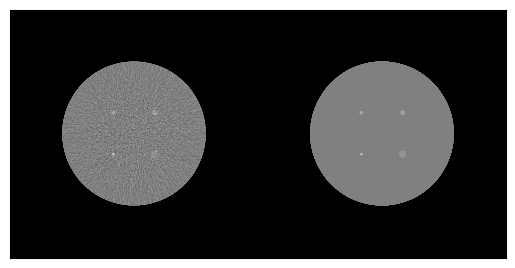

In [11]:
from utils import ctshow
ctshow(np.concatenate([sp_vol[0], sp_gt_vol], axis=1), (40, 0))

In [12]:
!which python

/home/brandon.nelson/miniconda3/envs/LCD_CT/bin/python


In [13]:
from LCD import measure_LCD

In [14]:
res = measure_LCD(sp_vol, sa_vol, sp_gt_vol, observers=['LG_CHO_2D', 'NPWE_2D'])
res.head()

/home/brandon.nelson/Dev/Regulatory_Science_Tools/LCD_CT/src/LCD












    _pyeval at line 57 column 30

    which at line 51 column 5
    /home/brandon.nelson/.local/share/octave/api-v59/packages/image-2.16.0/x86_64-conda-linux-gnu-api-v59/PKG_ADD at line 2 column 1
    load_packages_and_dependencies at line 56 column 5
    load_packages at line 53 column 3
    pkg at line 639 column 7
    measure_LCD at line 18 column 3
    _pyeval at line 57 column 30

    which at line 51 column 5
    /home/brandon.nelson/.local/share/octave/api-v59/packages/image-2.16.0/x86_64-conda-linux-gnu-api-v59/PKG_ADD at line 4 column 1
    load_packages_and_dependencies at line 56 column 5
    load_packages at line 53 column 3
    pkg at line 639 column 7
    measure_LCD at line 18 column 3
    _pyeval at line 57 column 30

    which at line 51 column 5
    /home/brandon.nelson/.local/share/octave/api-v59/packages/image-2.16.0/x86_64-conda-linux-gnu-api-v59/PKG_ADD at line 6 column 1
    load_packages_and_dependencies at line 56 column 5
    load_packages at line 53

,observer,insert_HU,snr,auc,reader
0,Laguerre-Gauss CHO 2D,5.0,0.133380,0.5526,1.0
1,Laguerre-Gauss CHO 2D,5.0,-0.080371,0.4875,2.0
2,Laguerre-Gauss CHO 2D,5.0,-0.086757,0.4681,3.0
3,Laguerre-Gauss CHO 2D,5.0,0.091279,0.5354,4.0
4,Laguerre-Gauss CHO 2D,5.0,0.108110,0.5307,5.0


If you get the error medfilt2 not found on your system, run the following:
```octave
pkg install -forge image
pkg load image
```

In [15]:
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='insert_HU', ylabel='auc'>

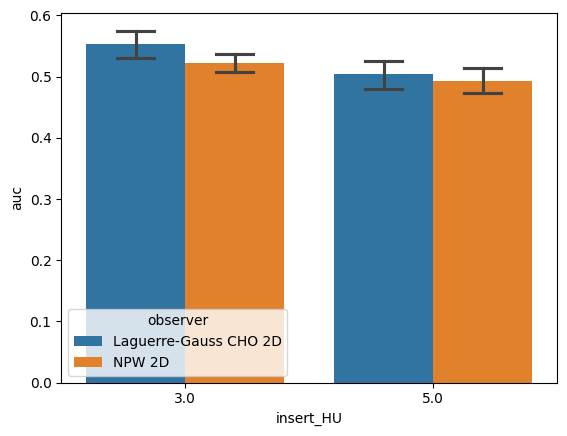

In [16]:
import seaborn as sns
sns.barplot(data=res, x='insert_HU', y='auc', capsize=0.3, hue='observer')

In [17]:
meta['recon'].unique()

array(['fbp'], dtype=object)

In [18]:
df_list = []
for dose in meta['Dose [%]'].dropna().unique():
    for diam in meta['effective diameter [cm]'].unique():
        for recon in meta['recon'].unique():
            sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]

            sa_fname = sample[sample.phantom=='uniform'].file
            sa_vol = np.array([load_dicom(o) for o in sa_fname])

            sp_fname = sample[sample.phantom=='MITA-LCD'].file
            sp_vol = np.array([load_dicom(o) for o in sp_fname])

            sp_gt_vol = load_dicom(meta[(meta['effective diameter [cm]']==diam) &
                                        (meta.phantom == 'MITA-LCD') &
                                        (meta.series == 'ground truth')].file.item())

            sample_df = measure_LCD(sp_vol, sa_vol, sp_gt_vol, observers=['LG_CHO_2D', 'NPWE_2D'])
            sample_df['effective diameter [cm]'] = diam
            sample_df['Dose [%]'] = dose
            sample_df['recon'] = recon
            df_list.append(sample_df)
results = pd.concat(df_list, ignore_index=True)

/home/brandon.nelson/Dev/Regulatory_Science_Tools/LCD_CT/src/LCD












    _pyeval at line 57 column 30

    get_demo_truth_masks at line 14 column 20
    measure_LCD at line 65 column 13
    _pyeval at line 57 column 30

    medfilt2 at line 55 column 11
    get_demo_truth_masks at line 14 column 20
    measure_LCD at line 65 column 13
    _pyeval at line 57 column 30

    medfilt2 at line 97 column 12
    get_demo_truth_masks at line 14 column 20
    measure_LCD at line 65 column 13
    _pyeval at line 57 column 30

    ordfiltn at line 80 column 5
    medfilt2 at line 97 column 12
    get_demo_truth_masks at line 14 column 20
    measure_LCD at line 65 column 13
    _pyeval at line 57 column 30

    pad_for_sliding_filter at line 28 column 8
    ordfiltn at line 80 column 5
    medfilt2 at line 97 column 12
    get_demo_truth_masks at line 14 column 20
    measure_LCD at line 65 column 13
    _pyeval at line 57 column 30

    ordfiltn at line 83 column 10
    medfilt2 at line 

In [19]:
results

,observer,insert_HU,snr,auc,reader,effective diameter [cm],Dose [%],recon
0,Laguerre-Gauss CHO 2D,5.0,0.055336,0.5186,1.0,20.0,10.0,fbp
1,Laguerre-Gauss CHO 2D,5.0,0.119311,0.5405,2.0,20.0,10.0,fbp
2,Laguerre-Gauss CHO 2D,5.0,0.040403,0.5096,3.0,20.0,10.0,fbp
3,Laguerre-Gauss CHO 2D,5.0,0.079721,0.5246,4.0,20.0,10.0,fbp
4,Laguerre-Gauss CHO 2D,5.0,0.093879,0.5265,5.0,20.0,10.0,fbp
...,...,...,...,...,...,...,...,...
395,NPW 2D,3.0,0.107753,0.5289,6.0,20.0,100.0,fbp
396,NPW 2D,3.0,0.208253,0.5600,7.0,20.0,100.0,fbp
397,NPW 2D,3.0,0.162545,0.5474,8.0,20.0,100.0,fbp
398,NPW 2D,3.0,0.178659,0.5645,9.0,20.0,100.0,fbp


In [21]:
results[results['Dose [%]'] == 60]

,observer,insert_HU,snr,auc,reader,effective diameter [cm],Dose [%],recon
200,Laguerre-Gauss CHO 2D,5.0,0.076467,0.5110,1.0,20.0,60.0,fbp
201,Laguerre-Gauss CHO 2D,5.0,0.213309,0.5694,2.0,20.0,60.0,fbp
202,Laguerre-Gauss CHO 2D,5.0,0.105027,0.5459,3.0,20.0,60.0,fbp
203,Laguerre-Gauss CHO 2D,5.0,0.088072,0.5270,4.0,20.0,60.0,fbp
204,Laguerre-Gauss CHO 2D,5.0,0.173638,0.5432,5.0,20.0,60.0,fbp
205,Laguerre-Gauss CHO 2D,5.0,-0.016509,0.5069,6.0,20.0,60.0,fbp
206,Laguerre-Gauss CHO 2D,5.0,0.050193,0.5113,7.0,20.0,60.0,fbp
207,Laguerre-Gauss CHO 2D,5.0,0.032623,0.5006,8.0,20.0,60.0,fbp
208,Laguerre-Gauss CHO 2D,5.0,0.050293,0.5012,9.0,20.0,60.0,fbp
209,Laguerre-Gauss CHO 2D,5.0,0.149926,0.5284,10.0,20.0,60.0,fbp


In [27]:
results['insert_HU'].unique()

array([5., 3.])

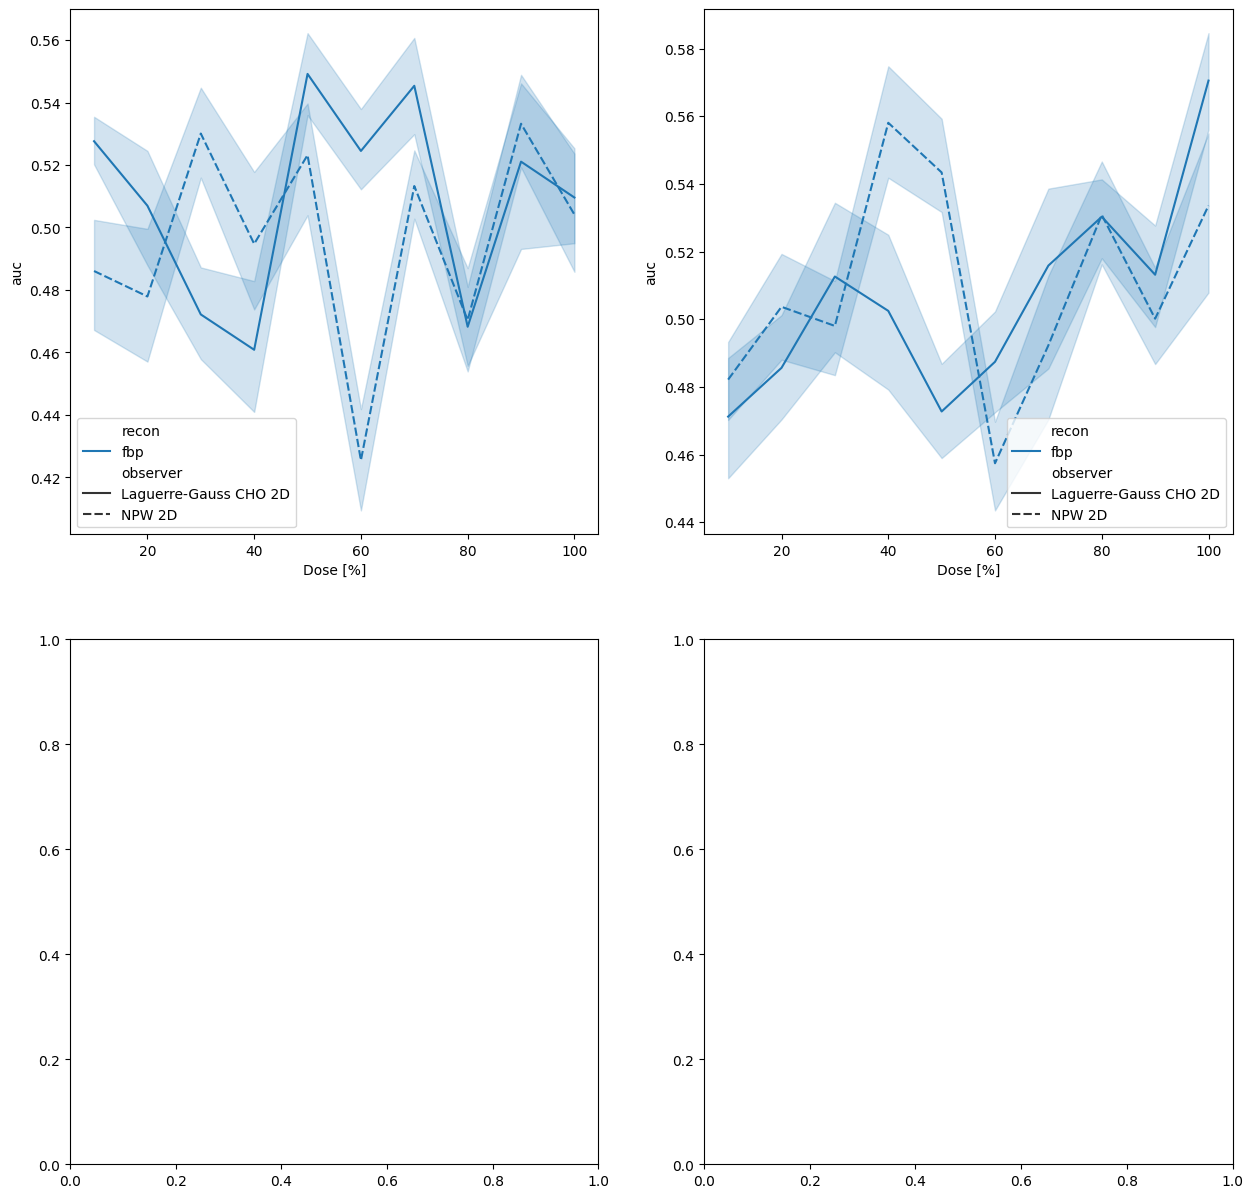

In [30]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(2, 2, figsize=(15,15))
for ax, hu in zip(axs.flatten(), results['insert_HU'].unique()):
    sns.lineplot(data=results[results['insert_HU']==hu],
                x='Dose [%]',
                y='auc',
                hue='recon',
                style='observer', ax=ax)

Looks like denoising only helps with the really low contrast and larger lesions